## Model with enriched data
The data downloaded from the internet to improve model performance.

* Size of LSOA (km)
* ONS rural urban definition of LSOA
* Number of schools in the local authroity that the LSOA is part of.
* Length of the road network in the local authroity that the LSOA is part of.
* Number of bus vehicle kilometers travelled annually in the local authroity that the LSOA is part of.
* Population of the LSOA

Plus calculate new variables like

* Population density
* Schools per population
* Bus kms travelled per km of road network
* ....

Try more complex models to match the increased data size. Regularised regression, decision trees and SVMs.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
def encode_categorical(df):
    new_df = df
    categorical_cols = ['Region', 'mode', 'nearest', 'urban_rural']
    for cat_colname in categorical_cols:
        levels = df[cat_colname].unique().tolist()
        for level in levels:
            new_colname = cat_colname + '_is_' + level
            new_df[new_colname] = new_df[cat_colname].apply(lambda x: x == level).astype(int)
    return(new_df)



### Load data and create new features. Take a subset to test models on

In [3]:
df = pd.read_csv('02-enriched-data.csv')

# Create new variables
df['pop_all'] = df.pop_u18 + df.pop_working_age + df.pop_retired_age
la_area = df.groupby('LA_Code').area_square_km.sum().reset_index().rename(columns={'area_square_km': 'area_square_km_LA'})
la_pop = df.groupby('LA_Code').pop_all.sum().reset_index().rename(columns={'pop_all': 'pop_all_LA'})
la_children = df.groupby('LA_Code').pop_u18.sum().reset_index().rename(columns={'pop_u18': 'pop_u18_LA'})
df = df.merge(la_area, how='left', on='LA_Code').merge(la_pop, how='left', on='LA_Code').merge(la_children, how='left', on='LA_Code')

df['pop_density'] = df.pop_all / df.area_square_km
df['pop_density_LA'] = df.pop_all_LA / df.area_square_km_LA
df['children_density'] = df.pop_u18 / df.area_square_km
df['children_density_LA'] = df.pop_u18_LA / df.area_square_km_LA
df['road_density_LA'] = df.road_LA_total_length_km / df.area_square_km_LA
df['school_density_LA'] = df.schools_all_LA / df.area_square_km_LA
df['bus_km_per_pop_LA'] = df.bus_LA_vehicle_km_travelled / df.pop_all_LA
df['bus_km_per_road_km_LA'] = df.bus_LA_vehicle_km_travelled / df.road_LA_total_length_km
df['bus_per_pop_LA'] = df.bus_LA_vehicle_km_travelled / df.pop_all_LA

df = encode_categorical(df)
rows_to_keep = df.nearest.apply(lambda x: x in ['primary_school', 'secondary_school', 'further_education'] )
cols_to_drop = ['LSOA_code', 'Region', 'LA_Code', 'LA_Name', 'year', 'mode', 'nearest', 'urban_rural',
               'nearest_is_GP', 'nearest_is_food', 'nearest_is_hospital', 'nearest_is_town_centre',
               'nearest_is_employment_centre']
df = df[rows_to_keep].drop(cols_to_drop, axis = 1)
df.to_csv('05-transformed-data.csv')

y = df.travel_time
df = df.drop('travel_time', axis=1)
X = StandardScaler().fit_transform(df)
feature_names = df.columns.values

# Reduce data size to around 50k points (use 7% of the data)
random_numbers = np.random.random(len(y))
X_short = X[random_numbers < 0.07, :]
y_short = y[random_numbers < 0.07]


In [4]:
X.shape

(591192, 50)

In [5]:
del(df)
del(X)
X_short.shape

(41402, 50)

In [6]:
pd.DataFrame(X_short, columns = feature_names).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
area_square_km,41402.0,0.005402,1.050508,-0.296783,-0.277615,-0.263897,-0.200425,50.277208
pop_u18,41402.0,-0.000626,0.999603,-2.739145,-0.664299,-0.153568,0.468886,10.954837
pop_working_age,41402.0,-0.002905,1.005625,-2.189652,-0.587323,-0.202900,0.338014,24.777779
pop_retired_age,41402.0,0.005106,1.003790,-2.248392,-0.713124,-0.117816,0.579320,7.464525
road_LA_minor_length_km,41402.0,0.008997,1.002665,-1.085980,-0.844126,-0.366282,0.623028,3.121039
road_LA_principal_length_km,41402.0,0.009001,1.002340,-1.123988,-0.892971,-0.421127,0.817761,2.650394
road_LA_total_length_km,41402.0,0.009047,1.002708,-1.093021,-0.851594,-0.342561,0.654930,3.021946
road_LA_trunk_length_km,41402.0,0.008480,1.003882,-0.948936,-0.819472,-0.364190,0.774014,2.610244
bus_LA_vehicle_km_travelled,41402.0,-0.003060,0.998511,-1.014213,-0.600228,-0.469552,0.177078,2.500625
schools_all_LA,41402.0,0.007330,1.002716,-1.384739,-0.830773,-0.378013,0.639366,2.279957


## Regression

In [7]:
lreg = LinearRegression()
scores = cross_val_score(estimator=lreg, X=X_short, y=y_short, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
average_error = np.sqrt(scores*-1).mean()
standard_deviation = np.sqrt(scores*-1).std()
standard_error = standard_deviation / np.sqrt(len(scores))
print('Average error ' + "{:.2f}".format(average_error) + ' minutes')
print('Standard error of the mean ' + "{:.2f}".format(standard_error) + ' minutes')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.

Average error 5.77 minutes
Standard error of the mean 0.71 minutes


## Regression (regularized)

In [8]:
reg = ElasticNetCV()
scores = cross_val_score(estimator=reg, X=X_short, y=y_short, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
average_error = np.sqrt(scores*-1).mean()
standard_deviation = np.sqrt(scores*-1).std()
standard_error = standard_deviation / np.sqrt(len(scores))
print('Average error ' + "{:.2f}".format(average_error) + ' minutes')
print('Standard error of the mean ' + "{:.2f}".format(standard_error) + ' minutes')

Average error 5.77 minutes
Standard error of the mean 0.73 minutes


### Regression parameters and coefficients

In [44]:
model = ElasticNetCV().fit(X_short, y_short)
predictions = model.predict(X_short)
coeficients = pd.DataFrame({
    'feature': feature_names,
    'coef': model.coef_
    })
coeficients['coef_abs'] = np.absolute(coeficients.coef)
predictions = model.predict(X_short)

In [45]:
print('Regularisation alpha '+'{:.2f}'.format(model.alpha_))
print('L1 ratio '+'{:.2f}'.format(model.l1_ratio_))
print('Intercept ' + '{:.2f}'.format(model.intercept_))
coeficients.sort_values('coef_abs', ascending=False)

Regularisation alpha 0.09
L1 ratio 0.50
Intercept 12.69


,coef,feature,coef_abs
39,-2.224542,nearest_is_primary_school,2.224542
36,-1.559519,mode_is_car,1.559519
44,1.511512,urban_rural_is_Rural village and dispersed,1.511512
0,1.303847,area_square_km,1.303847
38,1.155642,mode_is_public transport,1.155642
41,1.044045,nearest_is_further_education,1.044045
45,0.807376,urban_rural_is_Rural town and fringe,0.807376
47,0.570028,urban_rural_is_Rural village and dispersed in ...,0.570028
18,-0.439608,pop_density,0.439608
4,0.287670,road_LA_minor_length_km,0.287670


### Residuals

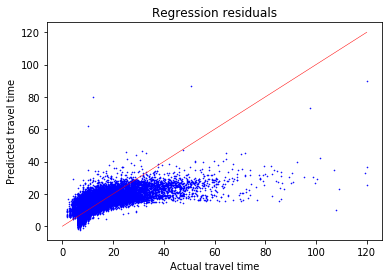

In [46]:
diag = np.linspace(0, 120)
plt.plot(y_short, predictions, 'bo', diag, diag, 'r-', markersize=0.6, linewidth=0.5)
plt.xlabel("Actual travel time")
plt.ylabel("Predicted travel time")
plt.title("Regression residuals")

## Random forests

In [12]:
rf = RandomForestRegressor()
scores = cross_val_score(estimator=rf, X=X_short, y=y_short, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
average_error = np.sqrt(scores*-1).mean()
standard_deviation = np.sqrt(scores*-1).std()
standard_error = standard_deviation / np.sqrt(len(scores))
print('Average error ' + "{:.2f}".format(average_error) + ' minutes')
print('Standard error of the mean ' + "{:.2f}".format(standard_error) + ' minutes')

Average error 5.31 minutes
Standard error of the mean 0.74 minutes


### Random forest variable importances

In [47]:
model = RandomForestRegressor().fit(X_short, y_short)
imp = pd.Series(model.feature_importances_, index=feature_names)
predictions = model.predict(X_short)

In [48]:
imp.sort_values(ascending=False)

nearest_is_primary_school                                         0.172031
pop_density                                                       0.158041
mode_is_car                                                       0.111137
children_density                                                  0.066500
area_square_km                                                    0.062169
mode_is_public transport                                          0.045302
pop_retired_age                                                   0.031308
pop_working_age                                                   0.028760
pop_u18                                                           0.025113
urban_rural_is_Rural town and fringe                              0.024609
pop_all                                                           0.023197
children_density_LA                                               0.022331
pop_density_LA                                                    0.016464
bus_km_per_road_km_LA    

## Random forest residuals

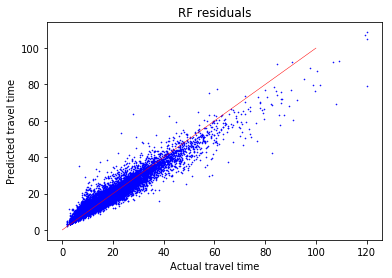

In [49]:
diag = np.linspace(0, 100)
plt.plot(y_short, predictions, 'bo', diag, diag, 'r-', markersize=0.6, linewidth=0.5)
plt.xlabel("Actual travel time")
plt.ylabel("Predicted travel time")
plt.title("RF residuals")

## Boosted trees

In [16]:
gbt = GradientBoostingRegressor()
scores = cross_val_score(estimator=gbt, X=X_short, y=y_short, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
average_error = np.sqrt(scores*-1).mean()
standard_deviation = np.sqrt(scores*-1).std()
standard_error = standard_deviation / np.sqrt(len(scores))
print('Average error ' + "{:.2f}".format(average_error) + ' minutes')
print('Standard error of the mean ' + "{:.2f}".format(standard_error) + ' minutes')

Average error 4.97 minutes
Standard error of the mean 0.66 minutes


### Variable importances

In [17]:
model = GradientBoostingRegressor().fit(X_short, y_short)
imp = pd.Series(model.feature_importances_, index=feature_names)
predictions = model.predict(X_short)

In [18]:
imp.sort_values(ascending=False)

pop_density                                                       0.111660
nearest_is_further_education                                      0.110396
mode_is_car                                                       0.109998
nearest_is_primary_school                                         0.097368
children_density                                                  0.073352
mode_is_public transport                                          0.065171
children_density_LA                                               0.037909
area_square_km                                                    0.035181
urban_rural_is_Rural village and dispersed in a sparse setting    0.030382
pop_density_LA                                                    0.029134
urban_rural_is_Rural town and fringe                              0.027830
urban_rural_is_Rural village and dispersed                        0.025322
pop_retired_age                                                   0.024279
road_LA_trunk_length_km  

### Residuals

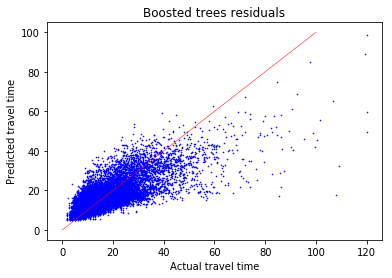

In [19]:
diag = np.linspace(0, 100)
plt.plot(y_short, predictions, 'bo', diag, diag, 'r-', markersize=0.6, linewidth=0.5)
plt.xlabel("Actual travel time")
plt.ylabel("Predicted travel time")
plt.title("Boosted trees residuals")

## Support Vector Machines

In [20]:
svm = SVR()
scores = cross_val_score(estimator=svm, X=X_short, y=y_short, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
average_error = np.sqrt(scores*-1).mean()
standard_deviation = np.sqrt(scores*-1).std()
standard_error = standard_deviation / np.sqrt(len(scores))
print('Average error ' + "{:.2f}".format(average_error) + ' minutes')
print('Standard error of the mean ' + "{:.2f}".format(standard_error) + ' minutes')

Average error 5.38 minutes
Standard error of the mean 0.82 minutes


### SVM residuals

In [21]:
model = SVR().fit(X_short, y_short)
predictions = model.predict(X_short)

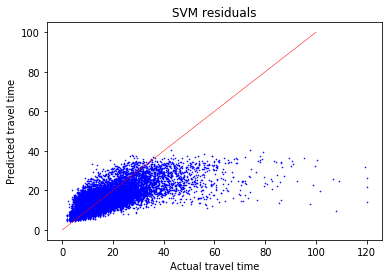

In [22]:
diag = np.linspace(0, 100)
plt.plot(y_short, predictions, 'bo', diag, diag, 'r-', markersize=0.6, linewidth=0.5)
plt.xlabel("Actual travel time")
plt.ylabel("Predicted travel time")
plt.title("SVM residuals")

## Stochastic gradient descent

In [27]:
#sgd = SGDRegressor()
#scores = cross_val_score(estimator=sgd, X=X_short, y=y_short, scoring='neg_mean_squared_error', cv=4, n_jobs=-1, verbose=4)
#average_error = np.sqrt(scores*-1).mean()
#standard_deviation = np.sqrt(scores*-1).std()
#standard_error = standard_deviation / np.sqrt(len(scores))
#print('Average error ' + "{:.2f}".format(average_error) + ' minutes')
#print('Standard error of the mean ' + "{:.2f}".format(standard_error) + ' minutes')

In [28]:
#model = SGDRegressor().fit(X_short, y_short)
#ceofs = pd.Series(model.coef_, index=feature_names)
#predictions = model.predict(X_short)

In [29]:
#coefs.sort_values(ascending=True)

In [30]:
#diag = np.linspace(0, 100)
#plt.plot(y_short, predictions, 'bo', diag, diag, 'r-', markersize=0.6, linewidth=0.5)
#plt.xlabel("Actual travel time")
#plt.ylabel("Predicted travel time")
#plt.title("SGD residuals")

## K Nearest Neighbours

In [31]:
knn = KNeighborsRegressor()
scores = cross_val_score(estimator=knn, X=X_short, y=y_short, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
average_error = np.sqrt(scores*-1).mean()
standard_deviation = np.sqrt(scores*-1).std()
standard_error = standard_deviation / np.sqrt(len(scores))
print('Average error ' + "{:.2f}".format(average_error) + ' minutes')
print('Standard error of the mean ' + "{:.2f}".format(standard_error) + ' minutes')

Average error 5.58 minutes
Standard error of the mean 0.74 minutes


In [32]:
model = KNeighborsRegressor().fit(X_short, y_short)
predictions = model.predict(X_short)

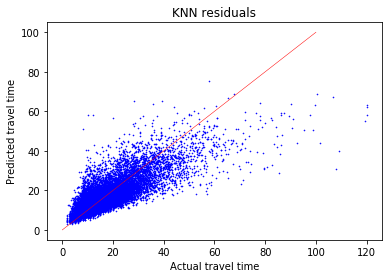

In [33]:
diag = np.linspace(0, 100)
plt.plot(y_short, predictions, 'bo', diag, diag, 'r-', markersize=0.6, linewidth=0.5)
plt.xlabel("Actual travel time")
plt.ylabel("Predicted travel time")
plt.title("KNN residuals")

## Extra trees regressor

In [34]:
etr = ExtraTreesRegressor()
scores = cross_val_score(estimator=etr, X=X_short, y=y_short, scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
average_error = np.sqrt(scores*-1).mean()
standard_deviation = np.sqrt(scores*-1).std()
standard_error = standard_deviation / np.sqrt(len(scores))
print('Average error ' + "{:.2f}".format(average_error) + ' minutes')
print('Standard error of the mean ' + "{:.2f}".format(standard_error) + ' minutes')

Average error 5.51 minutes
Standard error of the mean 0.79 minutes


### Variable importances and residuals

In [35]:
model = ExtraTreesRegressor().fit(X_short, y_short)
imp = pd.Series(model.feature_importances_, index=feature_names)
predictions = model.predict(X_short)

In [36]:
imp.sort_values(ascending=False)

nearest_is_primary_school                                         0.142172
mode_is_car                                                       0.122630
urban_rural_is_Rural village and dispersed                        0.116293
area_square_km                                                    0.074483
urban_rural_is_Rural town and fringe                              0.046671
urban_rural_is_Rural village and dispersed in a sparse setting    0.040390
children_density                                                  0.035732
pop_density                                                       0.034343
pop_retired_age                                                   0.029484
mode_is_public transport                                          0.025321
pop_u18                                                           0.024171
pop_all                                                           0.023490
pop_working_age                                                   0.022789
children_density_LA      

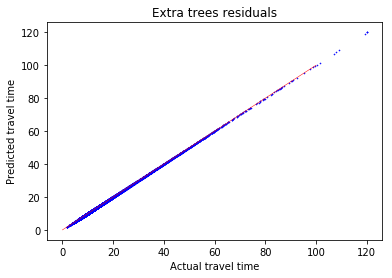

In [37]:
diag = np.linspace(0, 100)
plt.plot(y_short, predictions, 'bo', diag, diag, 'r-', markersize=0.6, linewidth=0.5)
plt.xlabel("Actual travel time")
plt.ylabel("Predicted travel time")
plt.title("Extra trees residuals")

# Scores 

In [43]:
pd.DataFrame([
    ('Regression', 5.77),
    ('Random Forest', 5.31),
    ('Boosted Trees', 4.97),
    ('Support vector machine', 5.38),
    ('K Nearest Neighbours', 5.58),
    ('Extra Trees', 5.51)
], columns = ['Model', 'Score']).sort_values('Score')

,Model,Score
2,Boosted Trees,4.97
1,Random Forest,5.31
3,Support vector machine,5.38
5,Extra Trees,5.51
4,K Nearest Neighbours,5.58
0,Regression,5.77
